In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [3]:
X_train = pd.read_csv("data/X_train.csv", index_col="id")
y_train = pd.read_csv("data/y_train.csv", index_col="id").to_numpy().ravel()

In [4]:
# ! pip install pyod

In [5]:
pre_od_pipeline = Pipeline(
    [
        ("imputer", IterativeImputer(initial_strategy="median", n_nearest_features=5)),
        ("scaler", StandardScaler()),
        ("selector", SelectKBest(score_func=f_regression, k=175)),
    ]
)

X_train_pre_od = pre_od_pipeline.fit_transform(X_train, y_train)

# Try ECOD

In [6]:
from pyod.models.ecod import ECOD

ecod_detector = ECOD()
ecod_detector.fit(X_train_pre_od)

# get outlier scores
y_train_scores = ecod_detector.decision_scores_  # raw outlier scores on the train data
y_train_pred_ecod = ecod_detector.labels_
# y_test_scores = ecod_detector.decision_function(X_test)  # predict raw outlier scores on test

# how many 0 and 1 in y_train_pred
print("Number of 0 in y_train_pred: ", len(y_train_pred_ecod[y_train_pred_ecod == 0]))
print("Number of 1 in y_train_pred: ", len(y_train_pred_ecod[y_train_pred_ecod == 1]))

Number of 0 in y_train_pred:  1090
Number of 1 in y_train_pred:  122


# Try IForest

In [7]:
from pyod.models.iforest import IForest

iforest_detector = IForest()
iforest_detector.fit(X_train_pre_od)
y_train_pred_iforest = iforest_detector.labels_

print(
    "Number of 0 in y_train_pred: ",
    len(y_train_pred_iforest[y_train_pred_iforest == 0]),
)
print(
    "Number of 1 in y_train_pred: ",
    len(y_train_pred_iforest[y_train_pred_iforest == 1]),
)

Number of 0 in y_train_pred:  1090
Number of 1 in y_train_pred:  122


# Try LOF local outlier factor

In [8]:
from pyod.models.lof import LOF

lof_detector = LOF()
lof_detector.fit(X_train_pre_od)
y_train_pred_lof = lof_detector.labels_

print("Number of 0 in y_train_pred: ", len(y_train_pred_lof[y_train_pred_lof == 0]))
print("Number of 1 in y_train_pred: ", len(y_train_pred_lof[y_train_pred_lof == 1]))

Number of 0 in y_train_pred:  1090
Number of 1 in y_train_pred:  122


# Try OCSVM

In [43]:
# OneClassSVM
from pyod.models.ocsvm import OCSVM

ocsvm_detector = OCSVM()
ocsvm_detector.fit(X_train_pre_od)
y_train_pred_ocsvm = ocsvm_detector.labels_

print("Number of 0 in y_train_pred: ", len(y_train_pred_ocsvm[y_train_pred_ocsvm == 0]))
print("Number of 1 in y_train_pred: ", len(y_train_pred_ocsvm[y_train_pred_ocsvm == 1]))

Number of 0 in y_train_pred:  1090
Number of 1 in y_train_pred:  122


# Try KNN

In [49]:
from pyod.models.knn import KNN

knn_detector = KNN()
knn_detector.fit(X_train_pre_od)
y_train_pred_knn = knn_detector.labels_

print("Number of 0 in y_train_pred: ", len(y_train_pred_knn[y_train_pred_knn == 0]))
print("Number of 1 in y_train_pred: ", len(y_train_pred_knn[y_train_pred_knn == 1]))

Number of 0 in y_train_pred:  1090
Number of 1 in y_train_pred:  122


# Try eliptic envelope


In [11]:
# from sklearn.covariance import EllipticEnvelope

# ee_detector = EllipticEnvelope(support_fraction=0.9, contamination=0.2)
# ee_detector.fit(X_train_pre_od)
# y_train_pred_ee = ee_detector.predict(X_train_pre_od)

# print("Number of 0 in y_train_pred: ", len(y_train_pred_ee[y_train_pred_ee == 0]))
# print("Number of 1 in y_train_pred: ", len(y_train_pred_ee[y_train_pred_ee == 1]))

# Try Minimum Covariance Determinant


In [12]:
# Minimum Covariance Determinant
from pyod.models.mcd import MCD

mcd_detector = MCD(support_fraction=0.9, contamination=0.1)
mcd_detector.fit(X_train_pre_od)
y_train_pred_mcd = mcd_detector.labels_

print("Number of 0 in y_train_pred: ", len(y_train_pred_mcd[y_train_pred_mcd == 0]))
print("Number of 1 in y_train_pred: ", len(y_train_pred_mcd[y_train_pred_mcd == 1]))

Number of 0 in y_train_pred:  1090
Number of 1 in y_train_pred:  122


# Try Z-Score

In [13]:
# Z-Score with a threshold of 2.5
from scipy import stats

threshold = 99
z_scores = stats.zscore(X_train_pre_od)
# combine the 200 features with z-scores to a single z-score for each sample
z_scores = z_scores.sum(axis=1)
y_train_pred_zscore = z_scores > threshold

print(
    "Number of 0 in y_train_pred: ", len(y_train_pred_zscore[y_train_pred_zscore == 0])
)
print(
    "Number of 1 in y_train_pred: ", len(y_train_pred_zscore[y_train_pred_zscore == 1])
)

Number of 0 in y_train_pred:  1110
Number of 1 in y_train_pred:  102


# Try DBSCAN

In [14]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan_detector = DBSCAN(
    eps=11.5,
    min_samples=5,
    algorithm="ball_tree",
    metric="minkowski",
    leaf_size=30,
    p=2,
)
y_train_pred_dbscan = dbscan_detector.fit_predict(X_train_pre_od)

# map everything that is not -1 to 0 and -1 to 1
y_train_pred_dbscan[y_train_pred_dbscan != -1] = 0
y_train_pred_dbscan[y_train_pred_dbscan == -1] = 1

print(
    "Number of 0 in y_train_pred: ", len(y_train_pred_dbscan[y_train_pred_dbscan == 0])
)
print(
    "Number of 1 in y_train_pred: ", len(y_train_pred_dbscan[y_train_pred_dbscan == 1])
)

Number of 0 in y_train_pred:  1111
Number of 1 in y_train_pred:  101


# Try Coreset

In [15]:
# !pip install dataheroes

In [16]:
import numpy as np
from dataheroes import CoresetTreeServiceDTC

coreset_tree = CoresetTreeServiceDTC(optimized_for="cleaning", n_instances=1212)
coreset_tree = coreset_tree.build(X=X_train_pre_od, y=y_train)
result = coreset_tree.get_cleaning_samples(1090)
# set the indices to 1 if the index is not in result["idx"]
y_train_pred_coreset = np.ones(len(y_train))
y_train_pred_coreset[result["idx"]] = 0

print(
    "Number of 0 in y_train_pred: ",
    len(y_train_pred_coreset[y_train_pred_coreset == 0]),
)
print(
    "Number of 1 in y_train_pred: ",
    len(y_train_pred_coreset[y_train_pred_coreset == 1]),
)

Number of 0 in y_train_pred:  1089
Number of 1 in y_train_pred:  123


# Make Plots

<BarContainer object of 10 artists>

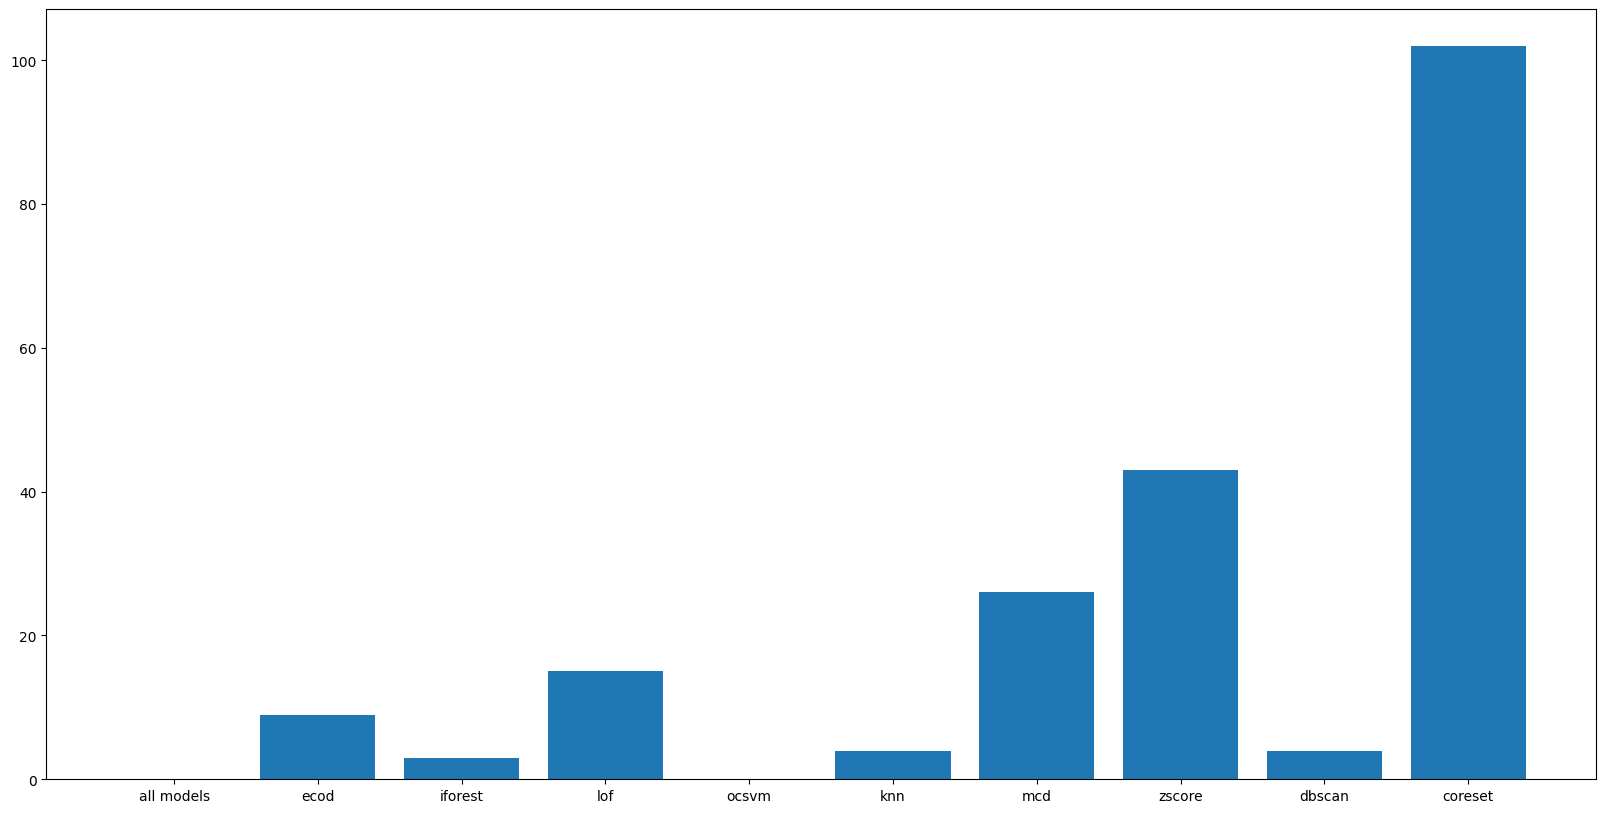

In [17]:
import matplotlib.pyplot as plt

all_models_outliers = (
    y_train_pred_ecod
    * y_train_pred_iforest
    * y_train_pred_lof
    * y_train_pred_ocsvm
    * y_train_pred_knn
    * y_train_pred_mcd
    * y_train_pred_zscore
    * y_train_pred_dbscan
    * y_train_pred_coreset
)

ecod_only_outliers = (
    y_train_pred_ecod
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
iforest_detector = (
    y_train_pred_iforest
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
lof_detector = (
    y_train_pred_lof
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
ocsvm_detector = (
    y_train_pred_ocsvm
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
knn_detector = (
    y_train_pred_knn
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
mcd_detector = (
    y_train_pred_mcd
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
zscore_detector = (
    y_train_pred_zscore
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
dbscan_detector = (
    y_train_pred_dbscan
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_coreset)
)
coreset_detector = (
    y_train_pred_coreset
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
)

plt.figure(figsize=(20, 10))
plt.bar(
    [
        "all models",
        "ecod",
        "iforest",
        "lof",
        "ocsvm",
        "knn",
        "mcd",
        "zscore",
        "dbscan",
        "coreset",
    ],
    [
        len(all_models_outliers[all_models_outliers == 1]),
        len(ecod_only_outliers[ecod_only_outliers == 1]),
        len(iforest_detector[iforest_detector == 1]),
        len(lof_detector[lof_detector == 1]),
        len(ocsvm_detector[ocsvm_detector == 1]),
        len(knn_detector[knn_detector == 1]),
        len(mcd_detector[mcd_detector == 1]),
        len(zscore_detector[zscore_detector == 1]),
        len(dbscan_detector[dbscan_detector == 1]),
        len(coreset_detector[coreset_detector == 1]),
    ],
)

# Discard the worst ones

<BarContainer object of 7 artists>

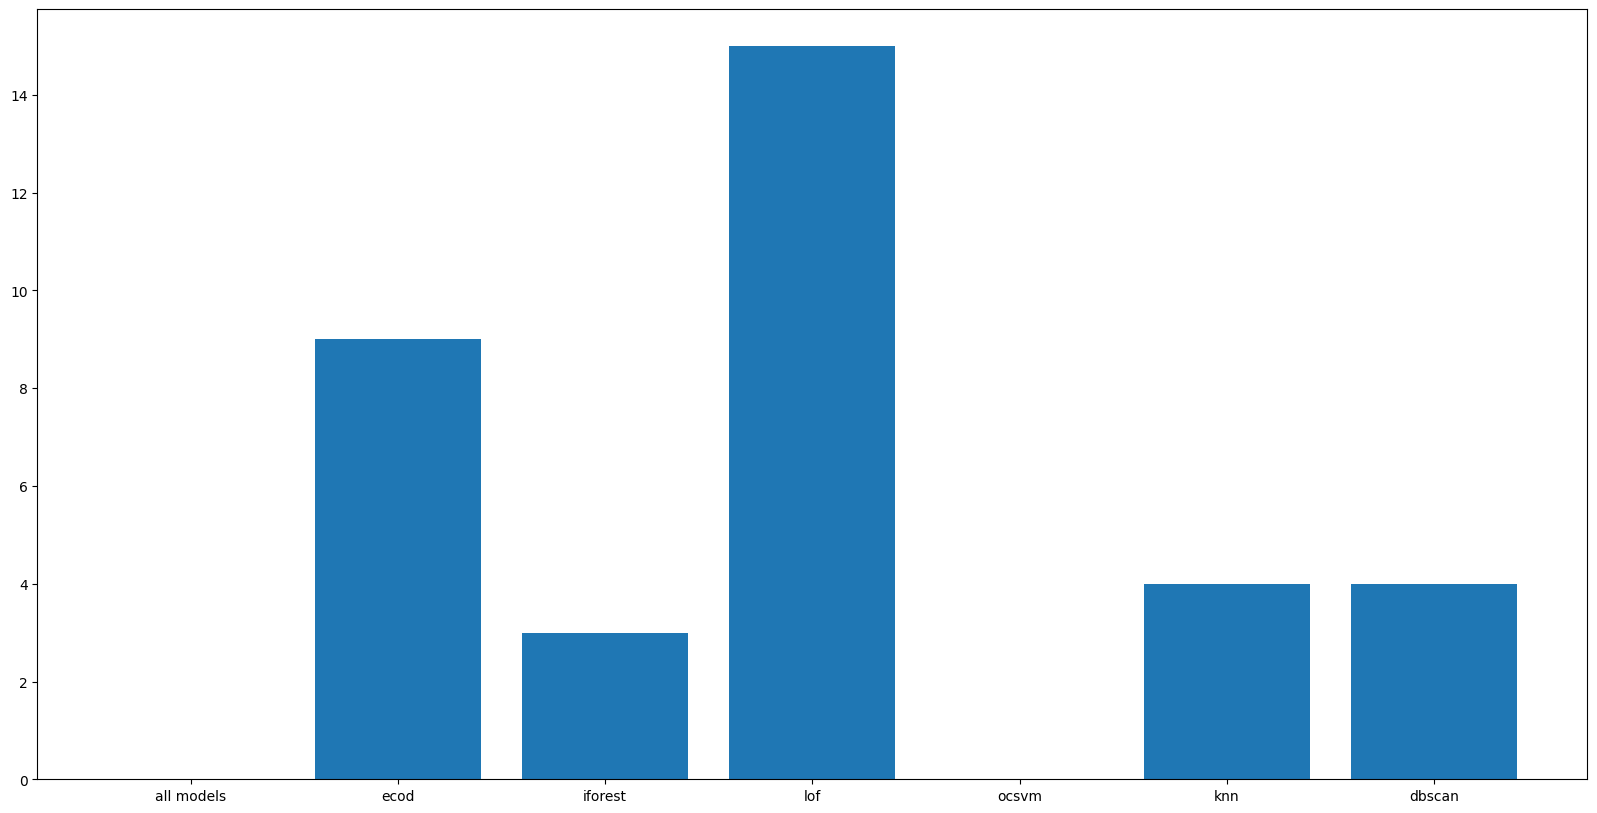

In [18]:
import matplotlib.pyplot as plt

all_models_outliers = (
    y_train_pred_ecod
    * y_train_pred_iforest
    * y_train_pred_lof
    * y_train_pred_ocsvm
    * y_train_pred_knn
    * y_train_pred_mcd
    * y_train_pred_zscore
    * y_train_pred_dbscan
    * y_train_pred_coreset
)

ecod_only_outliers = (
    y_train_pred_ecod
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
iforest_detector = (
    y_train_pred_iforest
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
lof_detector = (
    y_train_pred_lof
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
ocsvm_detector = (
    y_train_pred_ocsvm
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
knn_detector = (
    y_train_pred_knn
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_dbscan)
    * (1 - y_train_pred_coreset)
)
dbscan_detector = (
    y_train_pred_dbscan
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_iforest)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_ocsvm)
    * (1 - y_train_pred_knn)
    * (1 - y_train_pred_mcd)
    * (1 - y_train_pred_zscore)
    * (1 - y_train_pred_coreset)
)

plt.figure(figsize=(20, 10))
plt.bar(
    [
        "all models",
        "ecod",
        "iforest",
        "lof",
        "ocsvm",
        "knn",
        "dbscan",
    ],
    [
        len(all_models_outliers[all_models_outliers == 1]),
        len(ecod_only_outliers[ecod_only_outliers == 1]),
        len(iforest_detector[iforest_detector == 1]),
        len(lof_detector[lof_detector == 1]),
        len(ocsvm_detector[ocsvm_detector == 1]),
        len(knn_detector[knn_detector == 1]),
        len(dbscan_detector[dbscan_detector == 1]),
    ],
)

# Plot the best 3 ones on similarity

<BarContainer object of 7 artists>

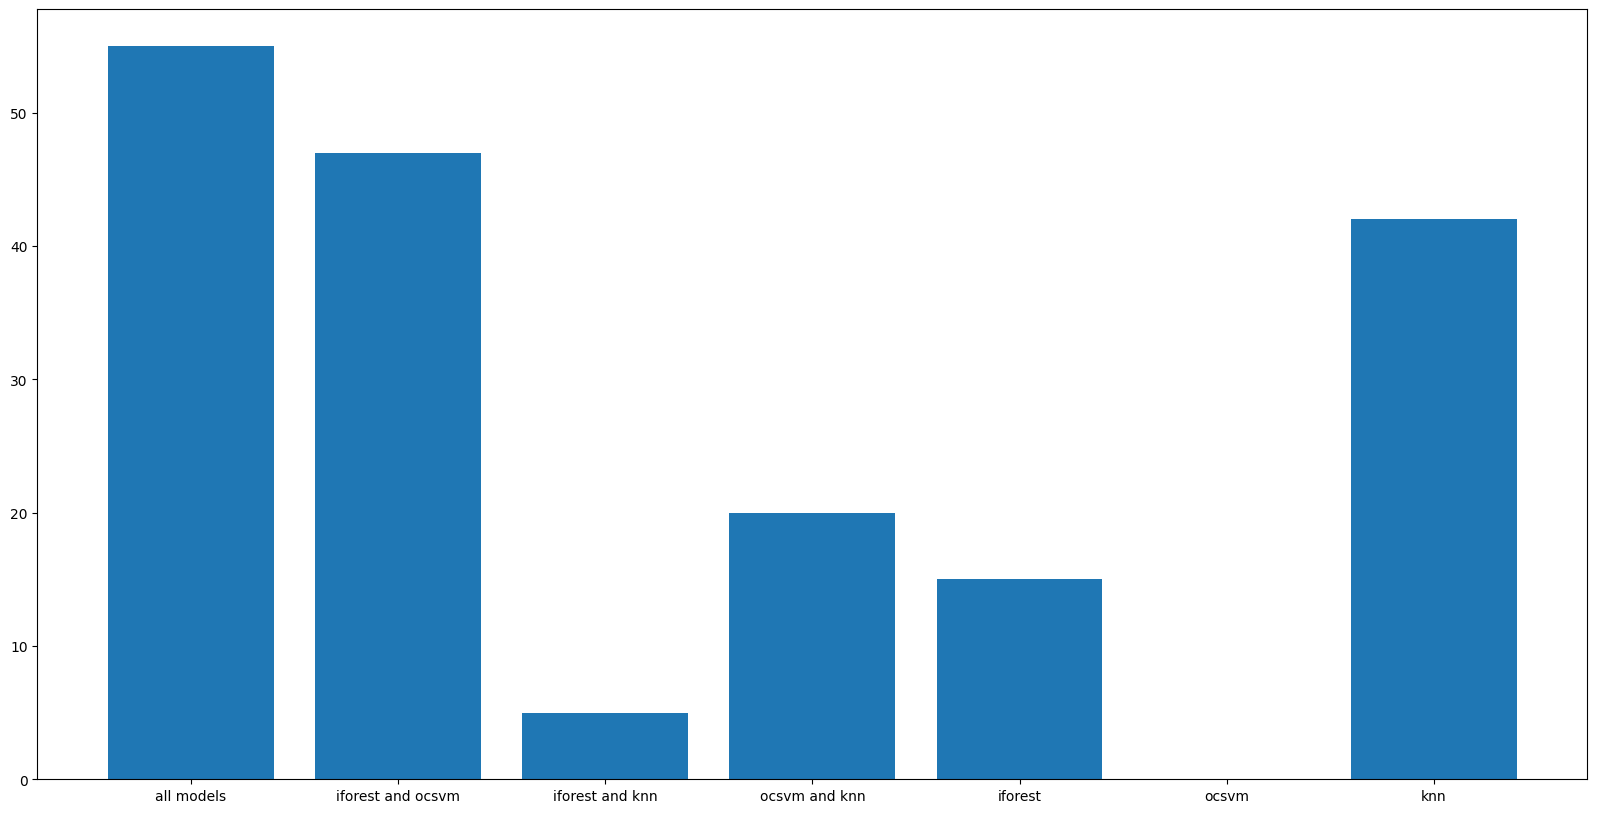

In [19]:
# make a plot showing the number of point ocsvm, knn and iforest label as 1, only ocsvm and knn labelled as 1, ocsvm and iforest labelled as 1, knn and iforest labelled as 1, only ocsvm labelled as 1, only knn labelled as 1, only iforest labelled as 1
import matplotlib.pyplot as plt

all_models_outliers = y_train_pred_iforest * y_train_pred_ocsvm * y_train_pred_knn

iforest_ocsvm_outliers = (
    y_train_pred_iforest * y_train_pred_ocsvm * (1 - y_train_pred_knn)
)

iforest_knn_outliers = (
    y_train_pred_iforest * y_train_pred_knn * (1 - y_train_pred_ocsvm)
)

ocsvm_knn_outliers = y_train_pred_ocsvm * y_train_pred_knn * (1 - y_train_pred_iforest)

iforest_outliers = (
    y_train_pred_iforest * (1 - y_train_pred_ocsvm) * (1 - y_train_pred_knn)
)

ocsvm_outliers = (
    y_train_pred_ocsvm * (1 - y_train_pred_iforest) * (1 - y_train_pred_knn)
)

knn_outliers = y_train_pred_knn * (1 - y_train_pred_iforest) * (1 - y_train_pred_ocsvm)

plt.figure(figsize=(20, 10))
plt.bar(
    [
        "all models",
        "iforest and ocsvm",
        "iforest and knn",
        "ocsvm and knn",
        "iforest",
        "ocsvm",
        "knn",
    ],
    [
        len(all_models_outliers[all_models_outliers == 1]),
        len(iforest_ocsvm_outliers[iforest_ocsvm_outliers == 1]),
        len(iforest_knn_outliers[iforest_knn_outliers == 1]),
        len(ocsvm_knn_outliers[ocsvm_knn_outliers == 1]),
        len(iforest_outliers[iforest_outliers == 1]),
        len(ocsvm_outliers[ocsvm_outliers == 1]),
        len(knn_outliers[knn_outliers == 1]),
    ],
)

# Majority vote

In [20]:
# Do a majority vote on the 3 models


def majority_vote(y_train_pred_ecod, y_train_pred_iforest, y_train_pred_knn):
    y_train_pred = np.zeros(len(y_train_pred_ecod))
    for i in range(len(y_train_pred_ecod)):
        # if two out of three models predict an outlier, then it is an outlier
        if (y_train_pred_ecod[i] + y_train_pred_iforest[i] + y_train_pred_knn[i]) >= 2:
            y_train_pred[i] = 1
    return y_train_pred


majority_voted = majority_vote(
    y_train_pred_ecod, y_train_pred_iforest, y_train_pred_knn
)
print("Number of found outliers: ", len(majority_voted[majority_voted == 1]))

Number of found outliers:  122


# Plot one vs rest for majority and the not part taking models

<BarContainer object of 5 artists>

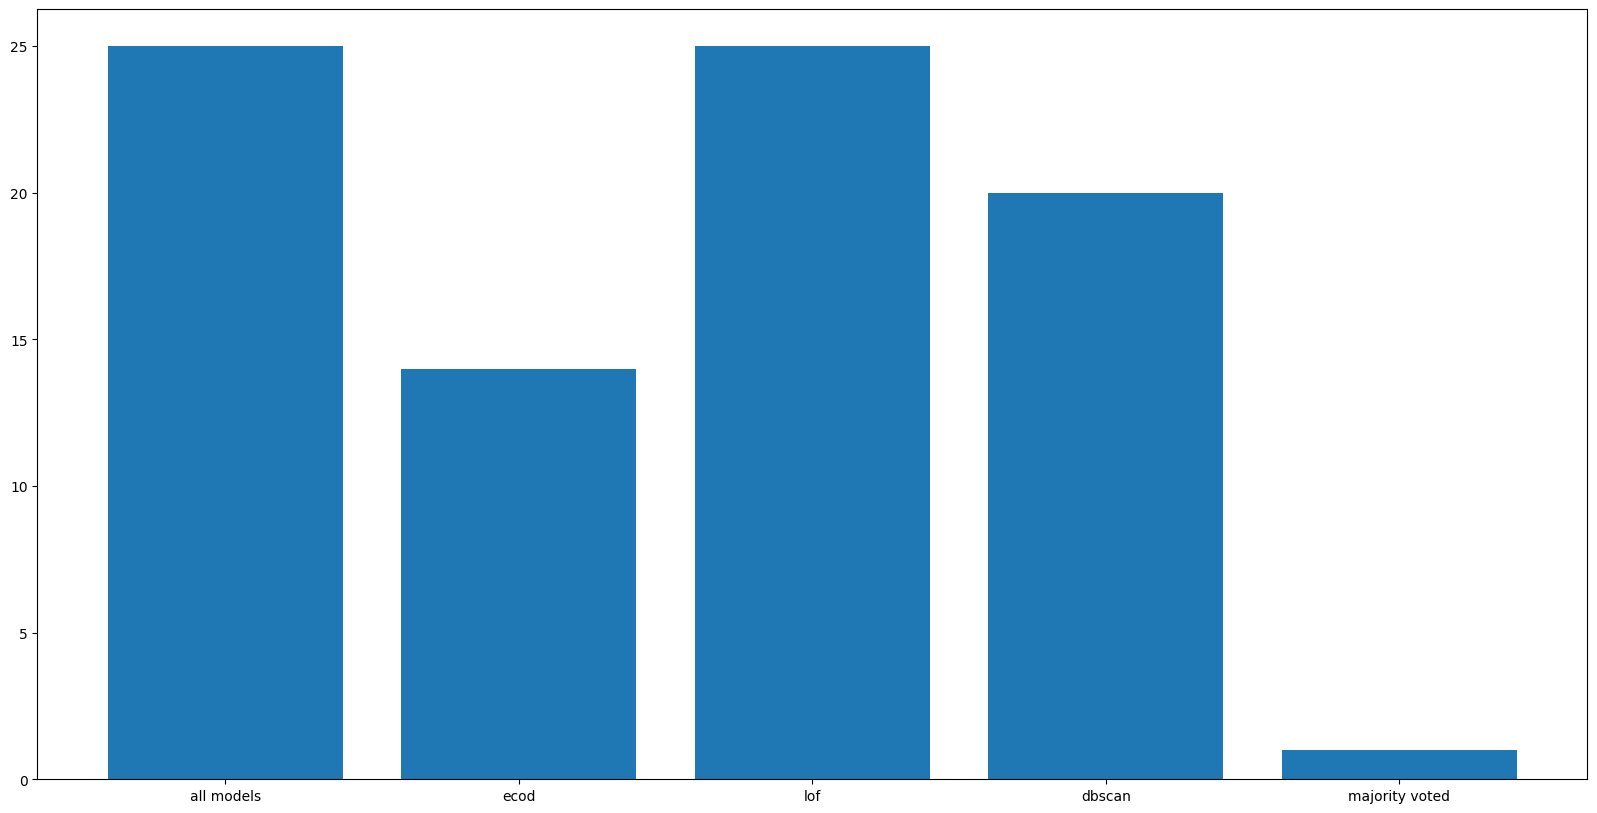

In [21]:
import matplotlib.pyplot as plt

all_models_outliers = (
    majority_voted * y_train_pred_ecod * y_train_pred_lof * y_train_pred_dbscan
)

ecod_only_outliers = (
    y_train_pred_ecod
    * (1 - majority_voted)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_dbscan)
)
lof_only_outliers = (
    y_train_pred_lof
    * (1 - majority_voted)
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_dbscan)
)
dbscan_only_outliers = (
    y_train_pred_dbscan
    * (1 - majority_voted)
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_lof)
)
majority_voted_only_outliers = (
    majority_voted
    * (1 - y_train_pred_ecod)
    * (1 - y_train_pred_lof)
    * (1 - y_train_pred_dbscan)
)


plt.figure(figsize=(20, 10))
plt.bar(
    [
        "all models",
        "ecod",
        "lof",
        "dbscan",
        "majority voted",
    ],
    [
        len(all_models_outliers[all_models_outliers == 1]),
        len(ecod_only_outliers[ecod_only_outliers == 1]),
        len(lof_only_outliers[lof_only_outliers == 1]),
        len(dbscan_only_outliers[dbscan_only_outliers == 1]),
        len(majority_voted_only_outliers[majority_voted_only_outliers == 1]),
    ],
)

As shown in the plot above the majority vote between ocsvm, iforest and knn contains most of the samples seen as outliers by the other models. That means we cover most of the distribution between them and keep the outliers. However we may keep to few. If we want to keep more, we can include more models in the majority vote.

In [40]:
# write the outliers to a csv file in the data folder as id, outlier
outliers = pd.DataFrame({"outlier": majority_voted}, index=X_train.index.astype(int))
outliers.to_csv("data/outliers_majority_vote_ocsvm_iforest_knn.csv")